In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
img = cv2.imread('cat.jpg')
img.shape

(340, 557, 3)

In [12]:
img = cv2.resize(img,(192,192))
img.shape

(192, 192, 3)

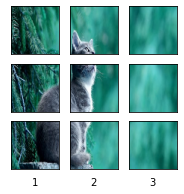

In [13]:
img_size = 192
patch_size = 64
num_patches = img_size//patch_size
patches = []

fig, axes = plt.subplots(nrows=img_size//patch_size,
                         ncols=img_size//patch_size,figsize=(num_patches, num_patches))


for i, ph in enumerate(range(0,img_size,patch_size)):
  for  j, pw in enumerate(range(0,img_size,patch_size)):

    axes[i,j].imshow(img[ph:ph+patch_size,pw:pw+patch_size,:])
    patches.append(img[ph:ph+patch_size,pw:pw+patch_size,:])
    axes[i, j].set_xlabel(j+1) 
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].label_outer()
                                
plt.show()

In [14]:
img1 = tf.expand_dims(img,0)
img1.shape

TensorShape([1, 192, 192, 3])

In [15]:
img2 = tf.identity(img1)
img3 = tf.identity(img1)
img4 = tf.identity(img1)
img5 = tf.identity(img1)

images = tf.concat([img1,img2,img3,img4,img5],axis=0)
images.shape

TensorShape([5, 192, 192, 3])

In [16]:
# image = tf.ones((1, 192, 192, 3))

# Patch size and stride
patch_size = [1, 64, 64, 1]
stride = [1, 64, 64, 1]

# Extract patches
patches = tf.image.extract_patches(images=images, sizes=patch_size, strides=stride, rates=[1, 1, 1, 1], padding='VALID')

# Reshape patches
num_patches = patches.shape[1] * patches.shape[2]
patches = tf.reshape(patches, (1,5, num_patches, patch_size[1], patch_size[2], 3))

print(patches.shape)

(1, 5, 9, 64, 64, 3)


In [70]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self,batch_size,num_patches,emb_size):
        
        positions = np.arange(num_patches)[:,np.newaxis]
        depth = np.arange(emb_size)[np.newaxis, :]
        depth = (2*depth//2)/emb_size

        angle_rates = 1 / (10000**depth)

        angle_rads  = positions * angle_rates
        angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
        angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])


        positions = positions * angle_rads
           
        self.pos = tf.constant(np.broadcast_to(positions,[batch_size,num_patches,emb_size]))
       
        
   
    def __call__(self):
        return self.pos

In [108]:
class LinearProjection(tf.keras.layers.Layer):

  def __init__(self,batch_size,num_patches,patch_size,projection=512):

    super().__init__()

    self.num_patches = num_patches
    self.patch_size = patch_size
    self.batch_size = batch_size
    self.lp = tf.keras.layers.Dense(projection,activation='relu')
    self.pos = PositionalEmbedding(batch_size,9,projection)

  def __call__(self,images):
    patch_sizes = [1, self.patch_size, self.patch_size, 1]
    stride = [1, self.patch_size, self.patch_size, 1]

    # Extract patches
    patches = tf.image.extract_patches(images=images, sizes=patch_sizes, strides=stride, rates=[1, 1, 1, 1], padding='VALID')

    # Reshape patches
    num_patches = patches.shape[1] * patches.shape[2]
    patches = tf.cast(patches,tf.float32)

    if self.batch_size>1:
      patches = tf.reshape(patches, (1,self.batch_size, num_patches, patch_size[1], patch_size[2], 3))
      patches = tf.reshape(patches,(self.batch_size,self.num_patches,-1))
    else:
      patches = tf.reshape(patches, (1, num_patches, patch_size[1], patch_size[2], 3))
      patches = tf.reshape(patches,(self.num_patches,-1))


    
    # # Linear Project 
    # patches = np.reshape(patches,(9,-1))
    project = self.lp(patches)
    pos = self.pos()
    projection_out = tf.cast(project,tf.float16) + tf.cast(pos,tf.float16)


    return projection_out

In [109]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self,emb_size,batch_size,heads=16):
        super(MultiHeadAttention,self).__init__()
        
        
        self.emb_size= emb_size
        self.batch_size = batch_size
        self.head_dim = emb_size//heads

        # Queries, Keys and Values Matrices Layers
        self.queries = tf.keras.layers.Dense(self.emb_size)
        self.keys = tf.keras.layers.Dense(self.emb_size)
        self.values = tf.keras.layers.Dense(self.emb_size)
      
    
    def self_attention(self,queries,keys,values):
        
        
        out = tf.matmul(queries,tf.transpose(keys,perm=[0, 2, 1]))
        out = out/np.sqrt(self.head_dim)

        out = tf.math.softmax(out)
        out = tf.matmul(out,values)
        
        return out 
    
     
    def __call__(self,x):
        
        
        
        # For Multiheaded Attention
        queries = self.queries(x)
        keys = self.keys(x)
        values = self.values(x)
    
        # Self Attention
        attention = self.self_attention(queries,keys,values)
        
        
        
            
        # Last matrix 
        
        out = tf.keras.layers.Dense(self.emb_size)(attention)
                          
        return out

In [110]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
               batch_size,
               emb_size=512,
               expansion_rate=4):
    
        super(Encoder,self).__init__()

        self.emb_size = emb_size
        self.batch_size = batch_size
        self.expansion_rate = expansion_rate

        self.mha = MultiHeadAttention(
                                  self.emb_size,
                                  self.batch_size)
        
        self.dense_1 = tf.keras.layers.Dense(int(self.emb_size*self.expansion_rate),activation='relu')
        self.dense_2 = tf.keras.layers.Dense(self.emb_size,activation='relu')

        self.layer_norm = tf.keras.layers.LayerNormalization()

  
    def __call__(self,x):

        self_attention = self.mha(x)

        x = tf.keras.layers.Add()([x,self_attention])

        x = self.layer_norm(x)

        dense = self.dense_1(x)
        dense = self.dense_2(dense)

        x = tf.keras.layers.Add()([dense,x])
        x = self.layer_norm(x)


        return x

In [111]:
class ViT(tf.keras.layers.Layer):
  
  def __init__(self,batch_size,num_patches,patch_size,emb_size=512):
    super().__init__()

    self.lp = LinearProjection(batch_size,num_patches,patch_size)
    self.encoder = Encoder(batch_size)


  def __call__(self,images):
    
    projection = self.lp(images)
   
    encoded_vector = self.encoder(projection)
    
    flatten =  tf.keras.layers.Flatten()(encoded_vector)

    out = tf.keras.layers.Dense(10,activation='softmax')(flatten)

    return out



In [112]:
input = tf.keras.Input(shape=(192,192,3))
vit = ViT(1,9,64)
out = vit(input)
out
model = tf.keras.Model(inputs=input, outputs=out)

Project Dim : (9, 512)
Postion (1, 9, 512)


In [113]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.extract_patches_10 (T  (None, 3, 3, 12288)  0          ['input_13[0][0]']               
 FOpLambda)                                                                                       
                                                                                                  
 tf.cast_20 (TFOpLambda)        (None, 3, 3, 12288)  0           ['tf.image.extract_patches_10[0][
                                                                 0]']                       